In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import r2_score

**Id** - идентификационный номер квартиры

**DistrictId** - идентификационный номер района

**Rooms** - количество комнат

**Square** - площадь

**LifeSquare** - жилая площадь

**KitchenSquare** - площадь кухни

**Floor** - этаж

**HouseFloor** - количество этажей в доме

**HouseYear** - год постройки дома

**Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности

**Social_1, Social_2, Social_3** - социальные показатели местности

**Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья

**Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров

**Price** - цена квартиры

In [2]:
DATASET_PATH = 'train.csv'
VALID_DATASET_PATH = 'test.csv'
PREPARED_VALID_DATASET_PATH = 'test_prepared.csv'
PREPARED_DATASET_PATH = 'train_prepared.csv'
PREDICTION_PATH = 'AAndreyankov_predictions.csv'

In [3]:
df = pd.read_csv(DATASET_PATH)

In [4]:
df.corrwith(df.Price)

Id               0.009880
DistrictId       0.265100
Rooms            0.550291
Square           0.520075
LifeSquare       0.081292
KitchenSquare    0.028864
Floor            0.128715
HouseFloor       0.088280
HouseYear        0.004305
Ecology_1       -0.058381
Social_1         0.263286
Social_2         0.239226
Social_3         0.074878
Healthcare_1     0.138755
Helthcare_2      0.253090
Shops_1          0.180876
Price            1.000000
dtype: float64

In [5]:
df_num_features = df.select_dtypes(include=['float64', 'int64'])
df_num_features.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,33,7976,5,NaN,0,11,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,46,10309,1,240.0,1,16,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,34,7759,0,229.0,1,3,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,23,5735,3,1084.0,0,5,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,35,5776,1,2078.0,2,4,150226.531644


In [6]:
df_obj_features = df.select_dtypes(include='object')
df_obj_features.head()

,Ecology_2,Ecology_3,Shops_2
0,B,B,B
1,B,B,B
2,B,B,B
3,B,B,B
4,B,B,B


In [7]:
Ecology_2_features = df['Ecology_2'].value_counts()
print(f'Признак Ecology_2:\n{Ecology_2_features}\n')
Ecology_3_features = df['Ecology_3'].value_counts()
print(f'Признак Ecology_3:\n{Ecology_3_features}\n')
Shops_2_features = df['Shops_2'].value_counts()
print(f'Признак Shops_2:\n{Shops_2_features}\n')

Признак Ecology_2:
B    9903
A      97
Name: Ecology_2, dtype: int64

Признак Ecology_3:
B    9725
A     275
Name: Ecology_3, dtype: int64

Признак Shops_2:
B    9175
A     825
Name: Shops_2, dtype: int64



Заменяем значения Ecology_2, Ecology_3 и Shops_2 на цифровые

In [8]:
df['Ecology_2'] = df['Ecology_2'].replace({ 'A': 0, 'B': 1,})
df['Ecology_3'] = df['Ecology_3'].replace({ 'A': 0, 'B': 1,})
df['Shops_2'] = df['Shops_2'].replace({ 'A': 0, 'B': 1,})

In [9]:
df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,0.990300,0.972500,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,0.917500,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,0.098015,0.163543,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,0.275139,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,1.000000,1.000000,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,1.000000,1.000000,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,1.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,1.000000,1.000000,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,1.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,1.000000,1.000000,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,1.000000,633233.466570



Смотрим данные по количеству комнат и избавляемся от выбросов:


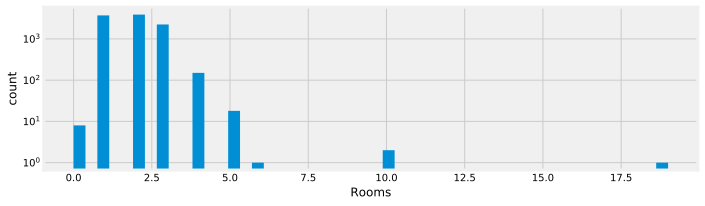

In [10]:
plt.figure(figsize = (23, 3))

plt.subplot(121)
df['Rooms'].hist(bins=50)
plt.ylabel('count')
plt.xlabel('Rooms')
plt.yscale('log')

In [11]:
rooms_median = df['Rooms'].median()
rooms_median

2.0

In [12]:
df.loc[(df['Rooms'] > 5) | (df['Rooms'] < 1), 'Rooms'] = rooms_median
df.loc[df['Rooms'] >= 5]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1422,4282,195,5.0,95.617533,62.377052,7.0,7,7.0,1940,0.015017,1,1,17,3079,59,2890.0,0,8,1,479525.147323
1503,1243,86,5.0,108.057398,82.723825,8.0,3,5.0,1942,0.161976,1,0,31,7010,5,4508.0,3,7,1,310305.074733
1982,5548,86,5.0,275.645284,233.949309,26.0,12,37.0,2011,0.161976,1,0,31,7010,5,4508.0,3,7,1,455264.882666
3268,8901,34,5.0,121.577423,114.913843,1.0,25,1.0,1977,0.069753,1,1,53,13670,4,NaN,1,11,1,455446.393758
3271,6358,27,5.0,42.003293,NaN,0.0,5,12.0,1977,0.011654,1,1,4,915,0,NaN,0,0,1,112693.641769
4431,7594,53,5.0,39.906082,39.394024,1.0,5,1.0,1977,0.049637,1,1,34,7759,0,229.0,1,3,1,206148.845716
4487,13434,13,5.0,183.382273,100.985505,15.0,2,6.0,1997,0.090799,1,1,74,19083,2,NaN,5,15,1,622888.825328
4762,4070,21,5.0,114.313752,88.492650,9.0,6,5.0,1960,0.034331,1,1,25,5487,3,NaN,0,4,1,499830.937577
5361,2879,78,5.0,118.871952,69.023509,10.0,15,16.0,1998,0.092291,1,1,21,4346,2,165.0,1,2,1,496026.671162
5466,3454,8,5.0,112.135525,79.795451,10.0,4,17.0,1999,0.437885,1,1,23,5735,3,1084.0,0,5,1,471833.787538


In [13]:
df.loc[(df['Id'] == 6358) | (df['Id'] == 7594), 'Square'] = df.loc[df['Rooms'] >= 5]['Square'].median()

Смотрим данные по общей площади и избавляемся от выбросов:

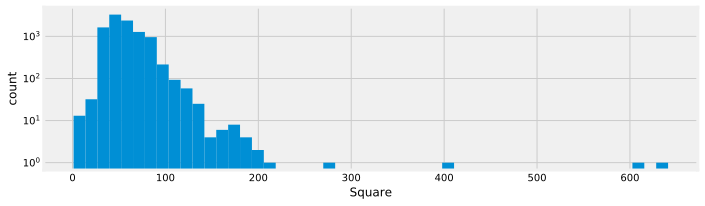

In [14]:
plt.figure(figsize = (23, 3))

plt.subplot(121)
df['Square'].hist(bins=50)
plt.ylabel('count')
plt.xlabel('Square')
plt.yscale('log')

In [15]:
square_mean = df['Square'].median()
square_mean

52.529412418953754

In [16]:
df.loc[(df['Square'] > 170) | (df['Square'] < 28), 'Square'] = square_mean

Смотрим данные по жилой площади и избавляемся от выбросов:

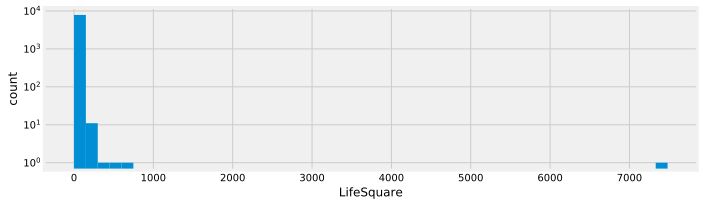

In [17]:
plt.figure(figsize = (23, 3))

plt.subplot(121)
df['LifeSquare'].hist(bins=50)
plt.ylabel('count')
plt.xlabel('LifeSquare')
plt.yscale('log')

In [18]:
lifesquare_median = df['LifeSquare'].median()
lifesquare_median

32.781260192155735

In [19]:
df.loc[(df['LifeSquare'] > 130) | (df['LifeSquare'] < 16), 'LifeSquare'] = lifesquare_median

Смотрим данные по площади кухни и избавляемся от выбросов:

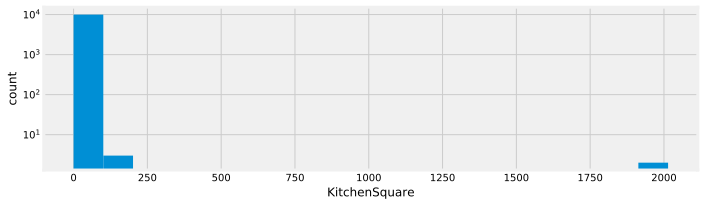

In [20]:
plt.figure(figsize = (23, 3))

plt.subplot(121)
df['KitchenSquare'].hist(bins=20)
plt.ylabel('count')
plt.xlabel('KitchenSquare')
plt.yscale('log')

In [21]:
kitchensquare_median = df['KitchenSquare'].median()
kitchensquare_median

6.0

In [22]:
df.loc[(df['KitchenSquare'] > 20)| (df['KitchenSquare'] < 5), 'KitchenSquare'] = kitchensquare_median

Смотрим есть ли неверные сочетания всех трёх площадей:

In [23]:
df.loc[df['Square'] < df['LifeSquare'] + df['KitchenSquare']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,1,1,23,5735,3,1084.0,0,5,1,175616.227217
14,10953,27,1.0,53.769097,52.408027,6.0,5,4.0,1977,0.072158,1,1,2,629,1,NaN,0,0,0,140647.565937
28,8054,23,1.0,42.530043,43.967759,6.0,3,9.0,2014,0.034656,1,1,0,168,0,NaN,0,0,1,95338.198549
42,9833,1,2.0,56.494318,54.723569,6.0,9,17.0,1977,0.007122,1,1,1,264,0,NaN,0,1,1,196078.907289
44,10521,38,3.0,104.211396,106.340403,6.0,20,0.0,2017,0.060753,1,1,15,2787,2,520.0,0,7,1,435462.048070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9949,3355,53,1.0,39.211416,36.159431,6.0,19,18.0,2019,0.049637,1,1,34,7759,0,229.0,1,3,1,180600.181118
9951,9237,25,1.0,33.516313,31.086243,6.0,13,11.0,2015,0.069753,1,1,53,13670,4,NaN,1,11,1,148066.435795
9964,10463,27,3.0,49.574590,45.590573,6.0,18,25.0,2013,0.072158,1,1,2,629,1,NaN,0,0,0,145025.095667
9974,2159,30,1.0,33.227093,32.639166,6.0,4,4.0,2016,0.000078,1,1,22,6398,141,1046.0,3,23,1,65949.315881


In [24]:
df.loc[df['Square'] < df['LifeSquare'] + df['KitchenSquare'], 'LifeSquare'] = df['Square'] / 1.2 - df['KitchenSquare']

In [25]:
coeff_sq_lsq = df['Square'].mean() / lifesquare_median
coeff_sq_lsq

1.715155518217784

In [26]:
df.loc[(df['LifeSquare'].isna() == True, 'LifeSquare')] = df['Square'] / coeff_sq_lsq

In [27]:
df.isna().sum(axis = 0)

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare          0
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

Смотрим данные по этажам квартир и избавляемся от выбросов:

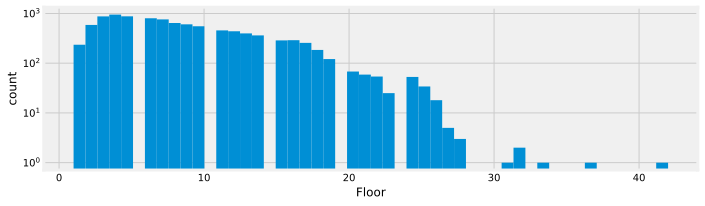

In [28]:
plt.figure(figsize = (23, 3))

plt.subplot(121)
df['Floor'].hist(bins=50)
plt.ylabel('count')
plt.xlabel('Floor')
plt.yscale('log')

In [29]:
floor_median = df['Floor'].median()
floor_median

7.0

In [30]:
df.loc[df['Floor'] > 35, 'Floor'] = floor_median

Смотрим данные по Social_1 и избавляемся от выбросов:

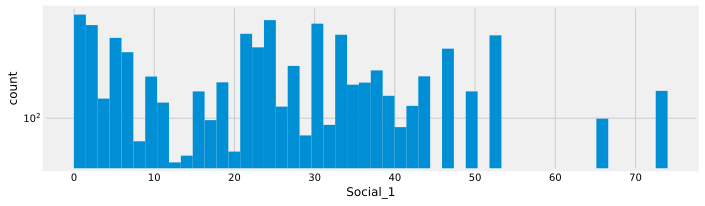

In [31]:
plt.figure(figsize = (23, 3))

plt.subplot(121)
df['Social_1'].hist(bins=50)
plt.ylabel('count')
plt.xlabel('Social_1')
plt.yscale('log')

In [32]:
social_1_median = df['Social_1'].median()
social_1_median

25.0

In [33]:
df.loc[df['Social_1'] > 60, 'Social_1'] = social_1_median

Смотрим данные по Social_2 и избавляемся от выбросов:

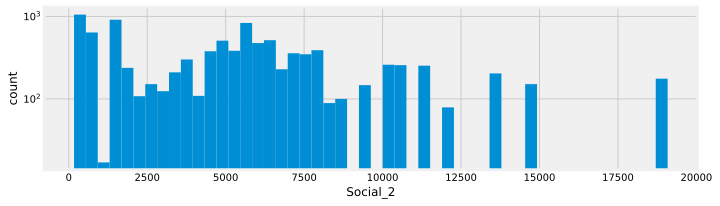

In [34]:
plt.figure(figsize = (23, 3))

plt.subplot(121)
df['Social_2'].hist(bins=50)
plt.ylabel('count')
plt.xlabel('Social_2')
plt.yscale('log')

In [35]:
social_2_median = df['Social_2'].median()
social_2_median

5285.0

In [36]:
df.loc[df['Social_2'] > 15000]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
12,6452,13,2.0,54.522805,31.759753,6.0,8.0,12.0,1999,0.090799,1,1,25.0,19083,2,NaN,5,15,1,229220.372609
198,10736,13,3.0,80.030330,47.801599,10.0,16.0,17.0,1992,0.090799,1,1,25.0,19083,2,NaN,5,15,1,311528.100863
278,8179,13,2.0,55.232957,32.530879,8.0,11.0,17.0,1998,0.090799,1,1,25.0,19083,2,NaN,5,15,1,237568.671581
325,10550,12,3.0,81.734269,48.328522,10.0,8.0,14.0,1995,0.090799,1,1,25.0,19083,2,NaN,5,15,1,289429.685423
377,5927,57,2.0,59.056975,36.223072,10.0,22.0,22.0,2002,0.090799,1,1,25.0,19083,2,NaN,5,15,1,317265.323792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9862,5785,13,1.0,42.053535,24.087096,10.0,11.0,22.0,2002,0.090799,1,1,25.0,19083,2,NaN,5,15,1,179540.436574
9872,14136,12,1.0,43.711302,20.130061,8.0,18.0,17.0,1989,0.090799,1,1,25.0,19083,2,NaN,5,15,1,171513.507717
9935,6608,13,2.0,59.384809,36.738844,10.0,2.0,16.0,1982,0.090799,1,1,25.0,19083,2,NaN,5,15,1,85665.844941
9956,10715,13,1.0,38.475794,20.461320,10.0,17.0,22.0,1997,0.090799,1,1,25.0,19083,2,NaN,5,15,1,178752.979404


Смотрим данные по Healthcare_2:

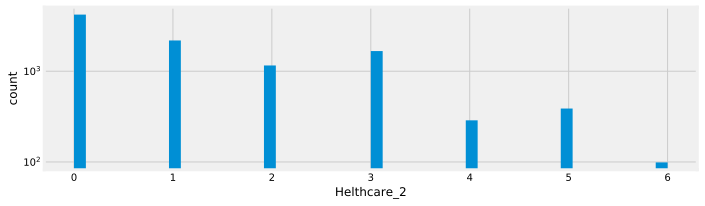

In [37]:
plt.figure(figsize = (23, 3))

plt.subplot(121)
df['Helthcare_2'].hist(bins=50)
plt.ylabel('count')
plt.xlabel('Helthcare_2')
plt.yscale('log')

In [38]:
helthcare_2_median = df['Helthcare_2'].median()
helthcare_2_median

1.0

Смотрим данные по Shops_2:

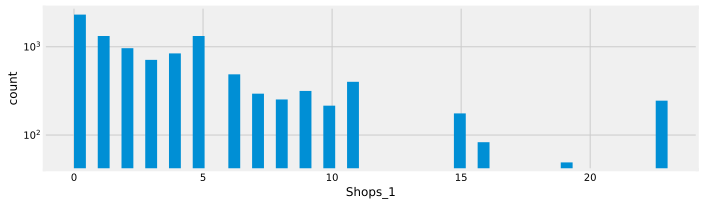

In [39]:
plt.figure(figsize = (23, 3))

plt.subplot(121)
df['Shops_1'].hist(bins=50)
plt.ylabel('count')
plt.xlabel('Shops_1')
plt.yscale('log')

Смотрим данные по году постройки дома и избавляемся от выбросов:

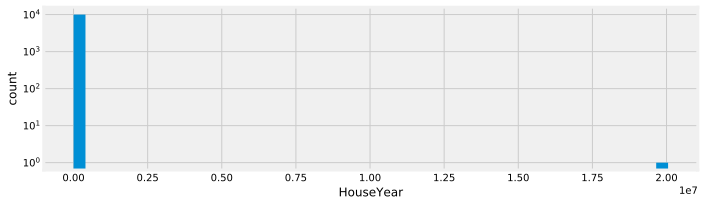

In [40]:
plt.figure(figsize = (23, 3))

plt.subplot(121)
df['HouseYear'].hist(bins=50)
plt.ylabel('count')
plt.xlabel('HouseYear')
plt.yscale('log')

In [41]:
houseyear_median = df['HouseYear'].median()
houseyear_median

1977.0

In [42]:
df.loc[(df['HouseYear'] > 2020) | (df['HouseYear'] < 1930), 'HouseYear'] = houseyear_median

Смотрим данные по Healthcare_1 и заполняем пропуски на основании Healthcare_2:

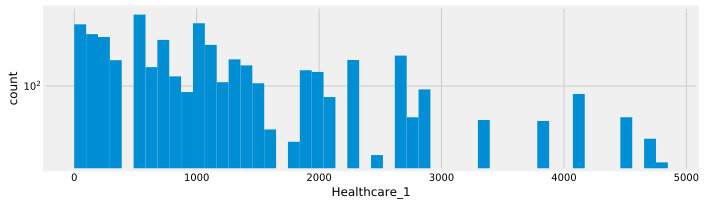

In [43]:
plt.figure(figsize = (23, 3))

plt.subplot(121)
df['Healthcare_1'].hist(bins=50)
plt.ylabel('count')
plt.xlabel('Healthcare_1')
plt.yscale('log')

In [44]:
coef_Healthcare = (df['Healthcare_1']/df['Helthcare_2']).median()
coef_Healthcare

571.4

In [45]:
df.loc[(df['Healthcare_1'].isna()) & (df['Helthcare_2'] != 0), 'Healthcare_1'] = df['Helthcare_2'] * coef_Healthcare

In [46]:
df.loc[(df['Healthcare_1'].isna(), 'Healthcare_1')] = df['Healthcare_1'].median()

Смотрим данные по количеству этажей дома и избавляемся от выбросов:

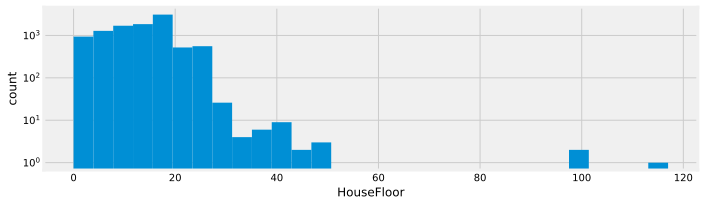

In [47]:
plt.figure(figsize = (23, 3))

plt.subplot(121)
df['HouseFloor'].hist(bins=30)
plt.ylabel('count')
plt.xlabel('HouseFloor')
plt.yscale('log')

In [48]:
housefloor_median = df['HouseFloor'].median()
housefloor_median

13.0

In [49]:
df.loc[(df['HouseFloor'] > 35) | (df['HouseFloor'] < 1), 'HouseFloor'] = housefloor_median

In [50]:
df.loc[df['Floor'] > df['HouseFloor']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
7,11993,74,2.0,80.312926,46.825448,6.0,14.0,13.0,1977.0,0.075779,1,1,6.0,1437,3,750.0,0,2,1,221244.156664
14,10953,27,1.0,53.769097,38.807581,6.0,5.0,4.0,1977.0,0.072158,1,1,2.0,629,1,750.0,0,0,0,140647.565937
16,2119,27,2.0,49.360648,31.993964,5.0,6.0,5.0,1983.0,0.051815,1,1,5.0,1227,0,750.0,0,0,1,117000.381287
21,11935,27,2.0,64.711835,37.729427,6.0,15.0,1.0,1977.0,0.211401,1,1,9.0,1892,0,750.0,0,1,1,127200.026511
26,4378,27,3.0,106.958871,32.781260,6.0,17.0,13.0,2018.0,0.072158,1,1,2.0,629,1,750.0,0,0,0,337299.867936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9984,2237,52,3.0,64.074977,47.633428,6.0,11.0,9.0,1983.0,0.371149,1,1,34.0,7065,1,750.0,2,5,1,226434.880156
9985,16159,27,1.0,38.968338,22.720003,6.0,10.0,1.0,1977.0,0.211401,1,1,9.0,1892,0,750.0,0,1,1,95529.569405
9989,4145,96,3.0,90.055233,47.860231,11.0,26.0,24.0,2005.0,0.041116,1,1,53.0,14892,4,571.4,1,4,1,441108.911237
9991,11553,3,3.0,101.622794,51.628780,12.0,18.0,17.0,2000.0,0.265089,1,1,37.0,5288,0,1937.0,3,2,1,212883.501504


In [51]:
df.loc[df['Floor'] > df['HouseFloor'], 'Floor'] = floor_median

In [52]:
df.loc[df['Floor'] > df['HouseFloor'], 'Floor'] = df['HouseFloor']

In [53]:
df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price']

In [54]:
feature_names = ['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2']
target_data = df['Price']

In [55]:
df.corrwith(df.Price)

Id               0.009880
DistrictId       0.265100
Rooms            0.571638
Square           0.578954
LifeSquare       0.547959
KitchenSquare    0.305931
Floor            0.093809
HouseFloor       0.075803
HouseYear        0.045510
Ecology_1       -0.058381
Ecology_2        0.022379
Ecology_3       -0.052585
Social_1         0.282103
Social_2         0.239226
Social_3         0.074878
Healthcare_1     0.160863
Helthcare_2      0.253090
Shops_1          0.180876
Shops_2          0.070388
Price            1.000000
dtype: float64

## Подготавливаем данные для обучения:

In [56]:
scaler = StandardScaler()
df_for_scaling = scaler.fit_transform(df[feature_names].astype(float))
df_scaled = pd.DataFrame(df_for_scaling, columns=feature_names)
df_scaled.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
count,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04
mean,2.241762e-16,-1.626033e-16,1.318501e-16,2.684741e-16,-1.689537e-16,3.560902e-17,-2.976730e-16,-3.220096e-15,5.593304e-17,1.130926e-15,-2.029599e-16,-1.772749e-16,5.659084e-17,-8.172851e-16,-6.472600e-17,-1.040990e-15,-1.531331e-16,5.780376e-16
std,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00
min,-1.156369e+00,-1.095417e+00,-1.533268e+00,-1.627602e+00,-1.088600e+00,-1.347653e+00,-1.942263e+00,-3.023846e+00,-9.986406e-01,-1.010410e+01,-5.946733e+00,-1.492940e+00,-1.293905e+00,-3.373466e-01,-1.224776e+00,-8.834798e-01,-8.804019e-01,-3.334848e+00
25%,-6.974994e-01,-1.095417e+00,-7.792871e-01,-8.218518e-01,-6.233666e-01,-7.184476e-01,-6.339344e-01,-6.036822e-01,-8.503701e-01,9.896975e-02,1.681596e-01,-1.110441e+00,-9.454794e-01,-3.373466e-01,-5.278343e-01,-8.834798e-01,-6.723330e-01,2.998637e-01
50%,-3.304041e-01,1.376053e-01,-2.014049e-01,-1.530334e-01,-6.233666e-01,-8.924229e-02,2.023003e-02,-4.386711e-01,-3.649310e-01,9.896975e-02,1.681596e-01,1.008078e-01,-1.676170e-02,-2.534212e-01,-3.099944e-01,-2.139233e-01,-2.561952e-01,2.998637e-01
75%,5.643907e-01,1.376053e-01,5.250251e-01,6.239808e-01,7.723344e-01,5.399631e-01,6.743944e-01,8.814180e-01,6.463114e-01,9.896975e-02,1.681596e-01,6.745571e-01,4.679386e-01,-1.275331e-01,1.534949e-01,4.556332e-01,3.680115e-01,2.998637e-01
max,3.638814e+00,3.836673e+00,6.173959e+00,7.282716e+00,5.889904e+00,5.154136e+00,3.127511e+00,1.926489e+00,3.386085e+00,9.896975e-02,1.681596e-01,1.885806e+00,3.427056e+00,5.579395e+00,4.689591e+00,3.133859e+00,3.905183e+00,2.998637e-01


In [57]:
X = df_scaled 
y = target_data

In [58]:
X

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,-0.353348,0.137605,-0.449260,-0.394956,-0.623367,-0.089242,-0.633934,-0.878701,-0.250529,0.09897,0.168160,0.610807,0.654880,-0.127533,-0.309994,-0.883480,1.408356,0.299864
1,-0.215687,1.370628,0.515492,0.452943,0.307101,-0.089242,-0.633934,-0.383667,-0.998053,0.09897,0.168160,1.439556,1.237169,-0.295384,-0.932046,-0.213923,2.448700,0.299864
2,0.059635,0.137605,-0.614590,-0.414553,-0.623367,0.120493,-0.143311,-0.933705,-0.581588,0.09897,0.168160,0.674557,0.600720,-0.337347,-0.945463,-0.213923,-0.256195,0.299864
3,0.174352,0.137605,-0.156521,0.086124,0.772334,0.120493,0.674394,-0.438671,2.680470,0.09897,0.168160,-0.026692,0.095553,-0.211458,0.097388,-0.883480,0.159943,0.299864
4,1.115034,-1.095417,-0.903369,-0.847939,-0.158133,0.749698,-0.143311,-0.493675,-0.894969,0.09897,0.168160,0.738307,0.105786,-0.295384,1.309779,0.455633,-0.048126,0.299864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-0.422178,0.137605,-0.317359,-0.312343,-1.088600,-0.508713,-1.288099,-0.933705,0.141089,0.09897,0.168160,1.439556,0.650887,-0.085570,-0.797878,1.125190,1.408356,0.299864
9996,-0.743386,-1.095417,-0.801327,-1.106698,0.772334,1.169168,0.020230,0.826414,-0.998641,0.09897,0.168160,0.419557,0.052374,-0.337347,-0.309994,-0.883480,0.159943,-3.334848
9997,-0.536895,-1.095417,-0.451579,-0.514267,-0.623367,0.959433,0.510853,1.651470,-0.392373,0.09897,0.168160,-1.365441,-1.178844,-0.295384,-0.309994,-0.883480,-0.880402,-3.334848
9998,0.564391,0.137605,-0.687913,-0.043432,0.307101,-1.347653,-1.288099,-1.318731,1.584694,0.09897,-5.946733,0.419557,-0.075914,0.040318,-0.828371,0.455633,0.159943,0.299864


In [59]:
X.isna().sum(axis = 0)

DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
dtype: int64

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [61]:
rf_model = RandomForestRegressor(max_depth=14)

In [62]:
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=14, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [63]:
params = {
    'n_estimators': [50, 100, 150, 200, 250, 300, 350],
    'max_depth': np.arange(5, 25),
}

gs = GridSearchCV(rf_model, params, scoring='r2', cv=3, n_jobs=-1)
gs.fit(X_train, y_train.values.ravel())

/home/creep/anaconda3/envs/gb_study/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=14,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [64]:
gs.best_params_

{'max_depth': 16, 'n_estimators': 350}

In [65]:
# final_model = RandomForestRegressor(n_estimators=300, max_depth=23, random_state=42)
# final_model.fit(X_train, y_train)

In [66]:
final_model = RandomForestRegressor(n_estimators=gs.best_params_['n_estimators'], max_depth=gs.best_params_['max_depth'], random_state=42)
final_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=16, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=350, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [67]:
y_pred_rfr = final_model.predict(X_test)
y_pred_rfr.shape

(1000,)

In [68]:
r2_score(y_test, y_pred_rfr)

0.691974656754984

## Заполняем данные на валидационном датасете по аналогии с исходным:

In [69]:
data_test = pd.read_csv(VALID_DATASET_PATH)
data_test

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,8180,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,B,B,36,5992,0,NaN,1,1,B
4996,4695,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,B,B,1,264,0,NaN,0,1,B
4997,5783,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,B,B,74,19083,2,NaN,5,15,B
4998,4780,62,2.0,81.305222,NaN,0.0,4,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A


In [70]:
data_test['Ecology_2'] = data_test['Ecology_2'].replace({ 'A': 0, 'B': 1,})
data_test['Ecology_3'] = data_test['Ecology_3'].replace({ 'A': 0, 'B': 1,})
data_test['Shops_2'] = data_test['Shops_2'].replace({ 'A': 0, 'B': 1,})
data_test

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,1,1,11,2748,1,NaN,0,0,1
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,1,1,6,1437,3,NaN,0,2,1
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,1,1,30,7538,87,4702.0,5,5,1
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,1,1,23,4583,3,NaN,3,3,1
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,1,1,2,629,1,NaN,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,8180,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,1,1,36,5992,0,NaN,1,1,1
4996,4695,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,1,1,1,264,0,NaN,0,1,1
4997,5783,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,1,1,74,19083,2,NaN,5,15,1
4998,4780,62,2.0,81.305222,NaN,0.0,4,0.0,1977,0.072158,1,1,2,629,1,NaN,0,0,0


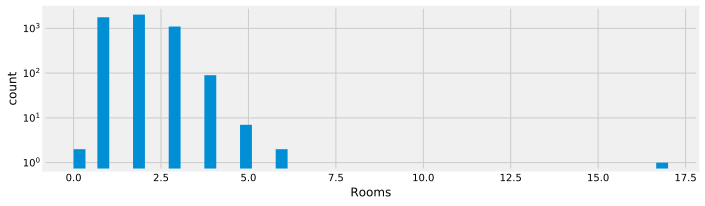

In [71]:
plt.figure(figsize = (23, 3))

plt.subplot(121)
data_test['Rooms'].hist(bins=50)
plt.ylabel('count')
plt.xlabel('Rooms')
plt.yscale('log')

In [72]:
data_test.loc[(data_test['Rooms'] > 5) | (data_test['Rooms'] < 1), 'Rooms'] = rooms_median
data_test.loc[data_test['Rooms'] >= 5]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
78,6553,34,5.0,122.375273,0.333490,0.0,9,0.0,1977,0.069753,1,1,53,13670,4,NaN,1,11,1
619,15858,9,5.0,97.537815,63.571997,8.0,5,14.0,1995,0.136244,1,1,11,2370,0,NaN,0,1,1
803,3747,23,5.0,139.045763,89.790274,42.0,1,3.0,2015,0.014073,1,1,2,475,0,NaN,0,0,1
1040,13562,78,5.0,116.656955,69.561006,10.0,5,14.0,2001,0.219006,1,1,28,6746,3,NaN,1,4,1
3253,12316,183,5.0,157.976101,101.040485,12.0,7,8.0,1908,0.246624,1,1,14,2940,45,NaN,3,6,1
3339,8638,25,5.0,120.330727,115.328430,1.0,14,25.0,2016,0.069753,1,1,53,13670,4,NaN,1,11,1
3912,6060,53,5.0,56.600162,2.742068,1.0,6,18.0,1977,0.049637,1,1,34,7759,0,229.0,1,3,1


In [73]:
data_test.loc[data_test['Id'] == 6060, 'Square'] = df.loc[df['Rooms'] >= 5]['Square'].median()

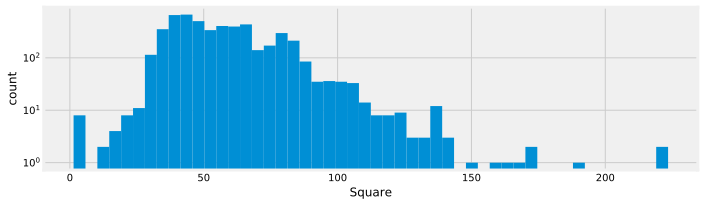

In [74]:
plt.figure(figsize = (23, 3))

plt.subplot(121)
data_test['Square'].hist(bins=50)
plt.ylabel('count')
plt.xlabel('Square')
plt.yscale('log')

In [75]:
data_test.loc[(data_test['Square'] > 140) | (data_test['Square'] < 28), 'Square'] = square_mean

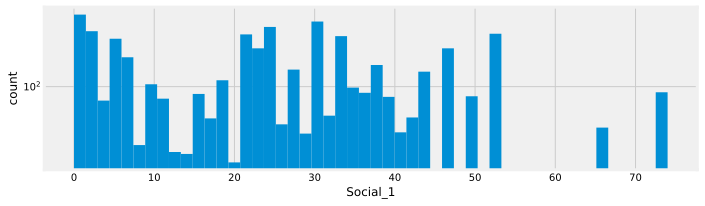

In [76]:
plt.figure(figsize = (23, 3))

plt.subplot(121)
data_test['Social_1'].hist(bins=50)
plt.ylabel('count')
plt.xlabel('Social_1')
plt.yscale('log')

In [77]:
data_test.loc[data_test['Social_1'] > 60, 'Social_1'] = social_1_median

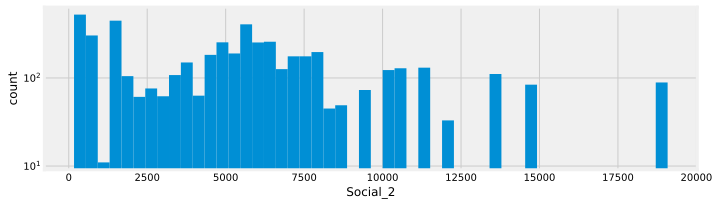

In [78]:
plt.figure(figsize = (23, 3))

plt.subplot(121)
data_test['Social_2'].hist(bins=50)
plt.ylabel('count')
plt.xlabel('Social_2')
plt.yscale('log')

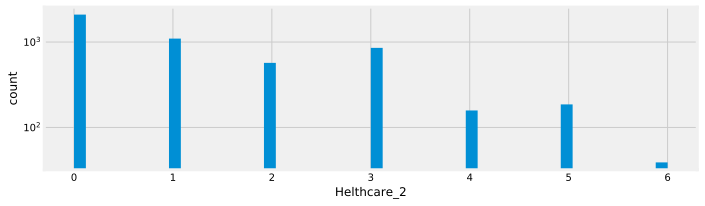

In [79]:
plt.figure(figsize = (23, 3))

plt.subplot(121)
data_test['Helthcare_2'].hist(bins=50)
plt.ylabel('count')
plt.xlabel('Helthcare_2')
plt.yscale('log')

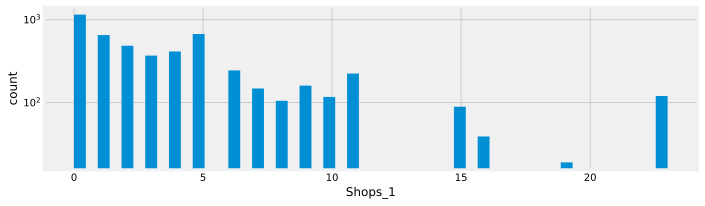

In [80]:
plt.figure(figsize = (23, 3))

plt.subplot(121)
data_test['Shops_1'].hist(bins=50)
plt.ylabel('count')
plt.xlabel('Shops_1')
plt.yscale('log')

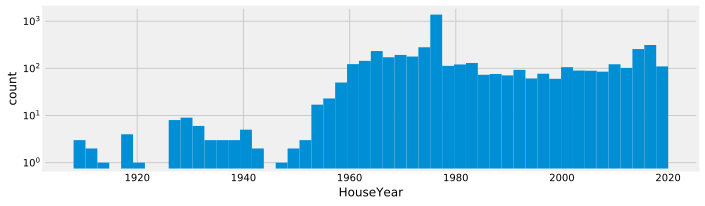

In [81]:
plt.figure(figsize = (23, 3))

plt.subplot(121)
data_test['HouseYear'].hist(bins=50)
plt.ylabel('count')
plt.xlabel('HouseYear')
plt.yscale('log')

In [82]:
data_test.loc[(data_test['HouseYear'] > 2020) | (data_test['HouseYear'] < 1930), 'HouseYear'] = houseyear_median

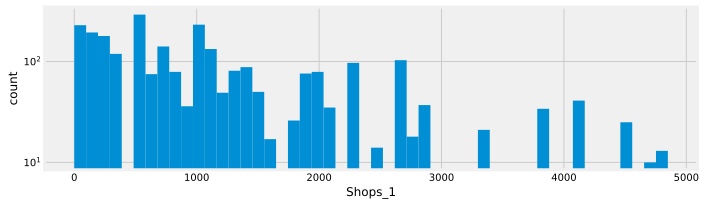

In [83]:
plt.figure(figsize = (23, 3))

plt.subplot(121)
data_test['Healthcare_1'].hist(bins=50)
plt.ylabel('count')
plt.xlabel('Shops_1')
plt.yscale('log')

In [84]:
data_test.loc[(data_test['Healthcare_1'].isna()) & (data_test['Helthcare_2'] != 0), 'Healthcare_1'] = data_test['Helthcare_2'] * coef_Healthcare

In [85]:
data_test.loc[(data_test['Healthcare_1'].isna(), 'Healthcare_1')] = data_test['Healthcare_1'].median()

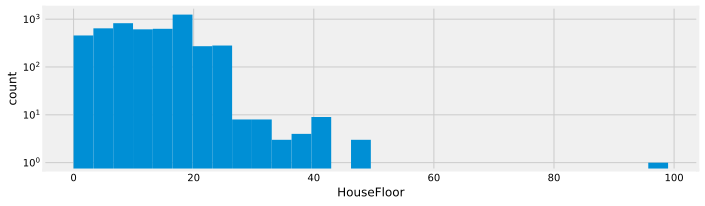

In [86]:
plt.figure(figsize = (23, 3))

plt.subplot(121)
data_test['HouseFloor'].hist(bins=30)
plt.ylabel('count')
plt.xlabel('HouseFloor')
plt.yscale('log')

In [87]:
data_test.loc[data_test['Floor'] > 35, 'Floor'] = floor_median

In [88]:
data_test.loc[(data_test['HouseFloor'] > 35) | (data_test['HouseFloor'] < 1), 'HouseFloor'] = housefloor_median

In [89]:
data_test.loc[data_test['Floor'] > data_test['HouseFloor']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
1,15856,74,2.0,69.263183,NaN,1.0,6.0,1.0,1977.0,0.075779,1,1,6.0,1437,3,730.0,0,2,1
10,15975,61,3.0,64.543658,42.651541,7.0,10.0,9.0,1981.0,0.300323,1,1,52.0,10311,6,571.4,1,9,1
14,5214,27,1.0,37.555197,NaN,1.0,5.0,1.0,1977.0,0.211401,1,1,9.0,1892,0,730.0,0,1,1
27,11160,58,1.0,48.610661,48.752502,1.0,4.0,3.0,1977.0,0.437885,1,1,23.0,5735,3,1084.0,0,5,1
32,2449,1,1.0,66.426585,NaN,0.0,14.0,13.0,1977.0,0.007122,1,1,1.0,264,0,730.0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4968,15181,27,4.0,104.664209,66.903563,1.0,4.0,1.0,2016.0,0.017647,1,1,2.0,469,0,730.0,0,0,1
4972,16064,30,1.0,38.376234,37.003311,1.0,2.0,1.0,1977.0,0.000078,1,1,22.0,6398,141,1046.0,3,23,1
4989,2591,39,2.0,44.203592,30.191691,6.0,10.0,9.0,1972.0,0.428826,1,1,25.0,5011,8,730.0,0,2,1
4993,14562,113,2.0,46.627882,27.058739,5.0,6.0,5.0,1969.0,0.307467,1,0,30.0,5048,9,325.0,2,5,1


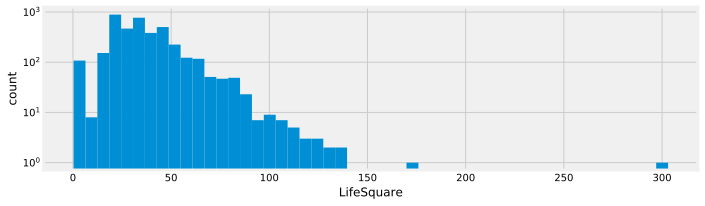

In [90]:
plt.figure(figsize = (23, 3))

plt.subplot(121)
data_test['LifeSquare'].hist(bins=50)
plt.ylabel('count')
plt.xlabel('LifeSquare')
plt.yscale('log')

In [91]:
data_test.loc[(data_test['LifeSquare'] > 130) | (data_test['LifeSquare'] < 16), 'LifeSquare'] = lifesquare_median

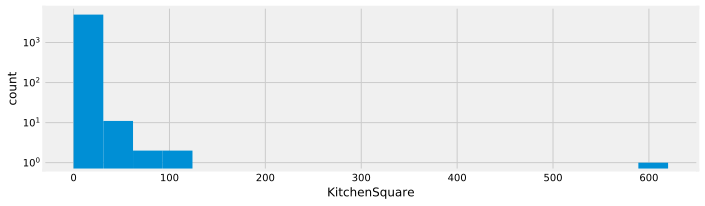

In [92]:
plt.figure(figsize = (23, 3))

plt.subplot(121)
data_test['KitchenSquare'].hist(bins=20)
plt.ylabel('count')
plt.xlabel('KitchenSquare')
plt.yscale('log')

In [93]:
data_test.loc[(data_test['KitchenSquare'] > 20)| (data_test['KitchenSquare'] < 5), 'KitchenSquare'] = kitchensquare_median

In [94]:
data_test.loc[data_test['Square'] < data_test['LifeSquare'] + data_test['KitchenSquare']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4,14275,27,1.0,47.527111,43.387569,6.0,17.0,17.0,2017.0,0.072158,1,1,2.0,629,1,730.0,0,0,0
6,13329,23,2.0,68.099538,64.843025,6.0,2.0,17.0,1977.0,0.075779,1,1,6.0,1437,3,730.0,0,2,1
27,11160,58,1.0,48.610661,48.752502,6.0,4.0,3.0,1977.0,0.437885,1,1,23.0,5735,3,1084.0,0,5,1
29,891,85,2.0,65.550690,61.689280,10.0,13.0,22.0,1988.0,0.037178,1,1,52.0,11217,1,2300.0,1,7,1
39,6624,27,1.0,42.413793,42.434887,10.0,12.0,17.0,2017.0,0.011654,1,1,4.0,915,0,730.0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4969,4821,74,2.0,82.542507,82.585069,6.0,4.0,17.0,2015.0,0.309479,1,1,35.0,7715,4,990.0,0,6,1
4972,16064,30,1.0,38.376234,37.003311,6.0,2.0,1.0,1977.0,0.000078,1,1,22.0,6398,141,1046.0,3,23,1
4974,5296,52,1.0,44.442218,44.634608,6.0,5.0,17.0,1977.0,0.371149,1,1,34.0,7065,1,750.0,2,5,1
4979,14090,2,1.0,39.082641,33.214358,7.0,10.0,14.0,1970.0,0.000000,1,1,33.0,7425,1,1142.8,2,5,1


In [95]:
data_test.loc[data_test['Square'] < data_test['LifeSquare'] + data_test['KitchenSquare'], 'LifeSquare'] = data_test['Square'] / 1.2 - data_test['KitchenSquare']

In [96]:
data_test.loc[(data_test['LifeSquare'].isna(), 'LifeSquare')] = data_test['Square'] / coeff_sq_lsq

In [97]:
data_test.isna().sum(axis = 0)

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
dtype: int64

In [98]:
data_test.loc[data_test['Floor'] > data_test['HouseFloor'], 'Floor'] = floor_median

In [99]:
data_test.loc[data_test['Floor'] > data_test['HouseFloor'], 'Floor'] = data_test['HouseFloor']

## Предсказываем цены:

In [100]:
# data_test_for_scaling = scaler.fit_transform(data_test[feature_names].astype(float))
data_test_for_scaling = scaler.transform(data_test[feature_names].astype(float))
data_test_scaled = pd.DataFrame(data_test_for_scaling, columns=feature_names)
data_test_scaled.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.020154,0.021948,0.011700,0.013893,-0.016144,0.015206,-0.007539,-0.017409,0.008540,0.001020,-0.014064,0.018507,0.013663,0.009374,-0.004662,-0.000067,0.002393,0.000363
std,1.013630,0.993736,0.982576,0.980585,0.981824,1.009430,1.003632,0.993001,1.008826,0.994982,1.039851,1.004966,1.004996,1.001388,1.024892,0.990903,0.994021,0.999548
min,-1.156369,-1.095417,-1.536880,-1.568907,-1.088600,-1.347653,-1.942263,-3.023846,-0.998641,-10.104097,-5.946733,-1.492940,-1.293905,-0.337347,-1.224776,-0.883480,-0.880402,-3.334848
25%,-0.674556,-1.095417,-0.770507,-0.798117,-0.623367,-0.718448,-0.633934,-0.658686,-0.834728,0.098970,0.168160,-1.110441,-0.945479,-0.337347,-0.527834,-0.883480,-0.672333,0.299864
50%,-0.307461,0.137605,-0.187107,-0.128078,-0.623367,-0.089242,0.020230,-0.438671,-0.392373,0.098970,0.168160,0.100808,-0.016762,-0.253421,-0.334389,-0.213923,-0.256195,0.299864
75%,0.610278,0.137605,0.545041,0.644964,0.772334,0.539963,0.674394,0.826414,0.646311,0.098970,0.168160,0.690495,0.482914,-0.127533,0.153495,0.455633,0.368011,0.299864
max,3.707644,3.836673,4.549816,7.050282,5.889904,5.154136,3.454593,1.926489,3.386085,0.098970,0.168160,1.885806,3.427056,5.579395,4.689591,3.133859,3.905183,0.299864


In [101]:
X = data_test_scaled[feature_names]

In [102]:
y_pred = final_model.predict(X)
y_pred

array([160360.45019008, 223266.15551195, 309596.15864266, ...,
       322287.46170948, 198988.56501436, 180840.47572077])

In [103]:
data_test["Price"] = y_pred

In [104]:
data_test.loc[:, ['Id', 'Price']].to_csv(PREDICTION_PATH, index=False)